<figure>
<img src="../Imagenes/logo-final-ap.png"  width="80" height="80" align="left"/> 
</figure>

# <span style="color:blue"><left>Aprendizaje Profundo</left></span>

# <span style="color:red"><center>Visión por Computadora</center></span>
## <span style="color:red"><center>Taller Transfer Learning: Piedra, papel o tijera</center></span>

##   <span style="color:blue">Profesores</span>

### Coordinador


- Campo Elías Pardo Turriago, cepardot@unal.edu.co 

### Conferencistas


- Alvaro  Montenegro, PhD, ammontenegrod@unal.edu.co
- Daniel  Montenegro, Msc, dextronomo@gmail.com 
- Oleg Jarma, Estadístico, ojarmam@unal.edu.co 

## <span style="color:blue">Asesora Medios y Marketing digital</span>

- Maria del Pilar Montenegro, pmontenegro88@gmail.com 



## <span style="color:blue">Asistentes</span>



- Nayibe Yesenia Arias, naariasc@unal.edu.co
- Venus Celeste Puertas, vpuertasg@unal.edu.co 

Continuando la demostración de transfer Learning, haremos un detector del juego "Piedra, papel o Tijeras"

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

import torchvision
from torchvision import transforms, models, datasets

device = 'cuda' if torch.cuda.is_available() else 'cpu'

import matplotlib.pyplot as plt
%matplotlib inline

## <span style="color:blue">Dataset RPS</span>



Dataset de manos generados con CGI haciendo las tres clásicas poses. Estas manos son de distintos tamaños, colores y están haciendo las poses con cierta variedad

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /mnt/storage/Datasets/rps/rps.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /mnt/storage/Datasets/rps/rps-test-set.zip



--2022-03-26 01:46:02--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.30.208, 172.217.172.16, 142.250.78.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.30.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/mnt/storage/Datasets/rps/rps.zip’

/mnt/storage/Datase 100%[===================>] 191.38M  9.83MB/s    in 18s     

2022-03-26 01:46:21 (10.5 MB/s) - ‘/mnt/storage/Datasets/rps/rps.zip’ saved [200682221/200682221]

--2022-03-26 01:46:21--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.78.144, 172.217.172.16, 142.250.78.16, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.78.144|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758

In [3]:
import os
import zipfile

local_zip = '/mnt/storage/Datasets/rps/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/mnt/storage/Datasets/rps')
zip_ref.close()
local_zip = '/mnt/storage/Datasets/rps/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip)
zip_ref.extractall('/mnt/storage/Datasets/rps')
zip_ref.close()

In [30]:

train_data_dir = '/mnt/storage/Datasets/rps/rps/'
test_data_dir = '/mnt/storage/Datasets/rps/rps-test-set/'

loader = transforms.Compose([
    transforms.Resize((224, 224)),
#     transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_data = datasets.ImageFolder(train_data_dir, transform=loader)
test_data = datasets.ImageFolder(test_data_dir, transform=loader)

valid_size = 0.2

num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = DataLoader(train_data, batch_size=24, 
                          num_workers=os.cpu_count(), pin_memory=True, 
                          sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=24, 
                          num_workers=os.cpu_count(), pin_memory=True, 
                          sampler=valid_sampler)
test_loader = DataLoader(test_data, batch_size=24, 
                         num_workers=os.cpu_count(), pin_memory=True)

(24, 3, 224, 224)
(23, 224, 224)


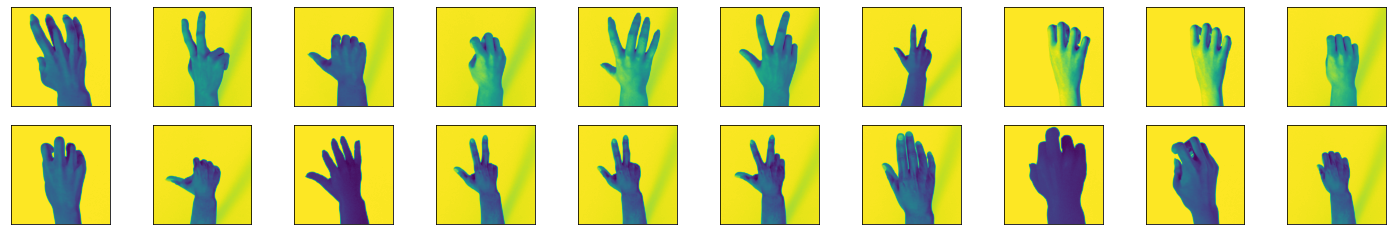

In [23]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()
print(images.shape)
images = images[1:,0,:,:]
print(images.shape)
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20//2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]))

In [31]:
def get_model():
    model = models.vgg16(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(512, 128),
        nn.ReLU(),
        nn.Dropout(0.4),
        nn.Linear(128,3),
    )
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
    return model.to(device), loss_fn, optimizer

model, loss_fn, optimizer = get_model()

In [32]:
n_epochs = 3

train_losslist = []
valid_loss_min = np.Inf 

for epoch in range(n_epochs):
    
    train_loss = 0.0
    valid_loss = 0.0
    
    model.train()
    for idx, (data, target) in enumerate(train_loader):
        data = data.to(device)
        target = target.to(device)
        
        optimizer.zero_grad()
        
        output = model(data)
        
        loss = loss_fn(output, target)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()*data.size(0)
        
    model.eval()
    for idx, (data, target) in enumerate(valid_loader):
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = loss_fn(output, target)
        
        valid_loss += loss.item()*data.size(0)
        
    train_loss = train_loss/len(train_loader.dataset)
    valid_loss = valid_loss/len(valid_loader.dataset)
    train_losslist.append(train_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    

Epoch: 0 	Training Loss: 0.465076 	Validation Loss: 0.031983
Epoch: 1 	Training Loss: 0.081184 	Validation Loss: 0.008143
Epoch: 2 	Training Loss: 0.030742 	Validation Loss: 0.003727


In [33]:
classes = ['Papel', 'Piedra', 'Tijera']
test_loss = 0.0
class_correct = list(0. for i in range(3))
class_total = list(0. for i in range(3))

model.eval()

for data, target in test_loader:
    
    data = data.to(device)
    target = target.to(device)
    
    output = model(data)
    loss = loss_fn(output, target)
    test_loss += loss.item()*data.size(0)
    
    _, pred = torch.max(output, 1) 
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    
    for i in range(12):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
    
test_loss = test_loss/len(test_loader.dataset)
print('Perdida de prueba: {:.6f}\n'.format(test_loss))

for i in range(3):
    if class_total[i] > 0:
        print('precisión de %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nPrecisión general: %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Perdida de prueba: 0.634036

precisión de Papel: 18% (12/64)
precisión de Piedra: 100% (64/64)
precisión de Tijera: 67% (43/64)

Precisión general: 61% (119/192)
